# **1. Problem Statement**
Forecast daily passenger throughput at Chicago O’Hare (ORD) 30 days in advance to optimize TSA checkpoint staffing and resource allocation.

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar

sns.set_style("whitegrid")



# **2. Data Loading & Quick Overview**

In [4]:
from google.colab import files
uploaded = files.upload()

df_raw = pd.read_csv('TsaThroughput.ORD.csv')
ord_cols = [c for c in df_raw.columns if c.startswith('ORD ')]
df = df_raw.copy()
df['pax']         = df[ord_cols].sum(axis=1)
df['date']        = pd.to_datetime(df['Date'])
df['hour']        = pd.to_datetime(df['Hour'], format='%H:%M:%S').dt.hour
df['day_of_week'] = df['date'].dt.day_name()
df['month']       = df['date'].dt.month_name()
df = df[['date','hour','day_of_week','month','pax']]

print(df.shape)
display(df.head())

Saving TsaThroughput.ORD.csv to TsaThroughput.ORD.csv
(56086, 5)


,date,hour,day_of_week,month,pax
0,2018-12-30,0,Sunday,December,153.0
1,2018-12-30,1,Sunday,December,38.0
2,2018-12-30,2,Sunday,December,80.0
3,2018-12-30,3,Sunday,December,885.0
4,2018-12-30,4,Sunday,December,3219.0


In [5]:
# Verify shape and list columns/types
print("Shape:", df.shape)
df.dtypes


Shape: (56086, 5)


,0
date,datetime64[ns]
hour,int32
day_of_week,object
month,object
pax,float64


In [6]:
print("Missing values per column:\n", df.isna().sum())
print("Duplicate rows:", df.duplicated().sum())


Missing values per column:
 date           0
hour           0
day_of_week    0
month          0
pax            0
dtype: int64
Duplicate rows: 0


# **Questions to ponder**
1.Does the data match your expectations or do you think you might need more information?
**Ans:**The dataset provides continuous hourly screening counts with no gaps—exactly what we need.

2.Do the columns/features align with your problem statement?
**Ans:**Yes,we have date, hour, day_of_week, month, and aggregated pax.

3.Any immediate signs of missing or corrupted data?
**Ans:** No missing or NaN values; the data appears clean.

# 3. Univariate Analysis
**3a. Numeric: Distribution of pax**

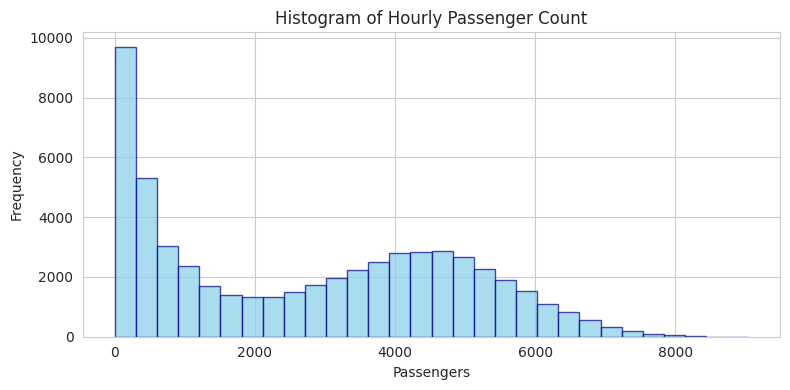

In [7]:

plt.figure(figsize=(8,4))
plt.hist(df['pax'], bins=30, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Histogram of Hourly Passenger Count')
plt.xlabel('Passengers')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


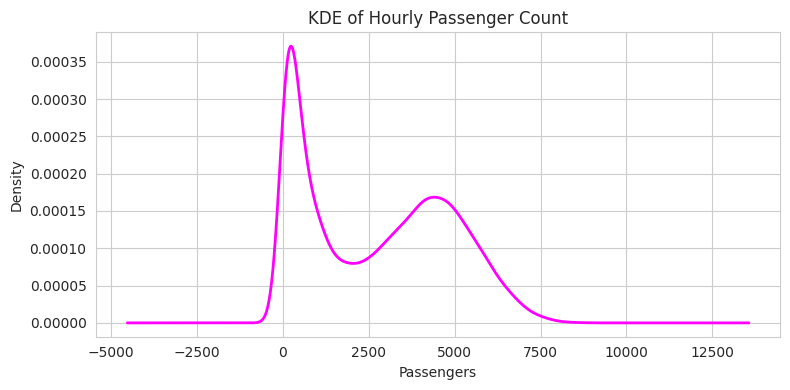

In [8]:
# KDE of pax
plt.figure(figsize=(8,4))
df['pax'].plot(kind='kde', color='magenta', lw=2)
plt.title('KDE of Hourly Passenger Count')
plt.xlabel('Passengers')
plt.tight_layout()
plt.show()


**3b. Categorical: Counts by hour, day, month**

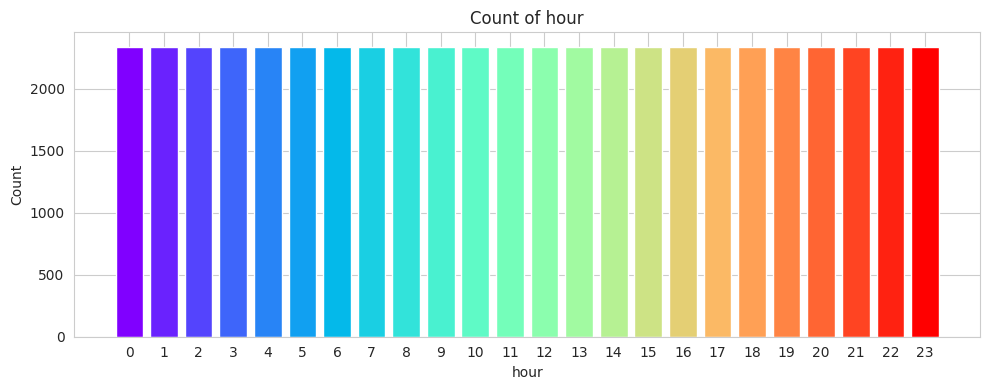

In [9]:
# Count of hour
counts = df['hour'].value_counts().sort_index()
colors = plt.colormaps['rainbow'](np.linspace(0,1,len(counts)))
plt.figure(figsize=(10,4))
plt.bar(counts.index, counts.values, color=colors)
plt.title('Count of hour')
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(counts.index)
plt.tight_layout()
plt.show()


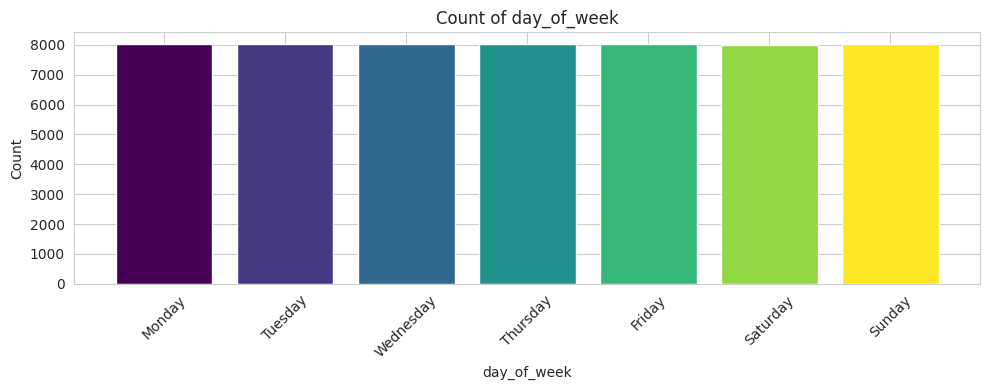

In [10]:
# Count of day_of_week
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
counts = df['day_of_week'].value_counts().reindex(order)
colors = plt.colormaps['viridis'](np.linspace(0,1,len(order)))
plt.figure(figsize=(10,4))
plt.bar(order, counts, color=colors)
plt.title('Count of day_of_week')
plt.xlabel('day_of_week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


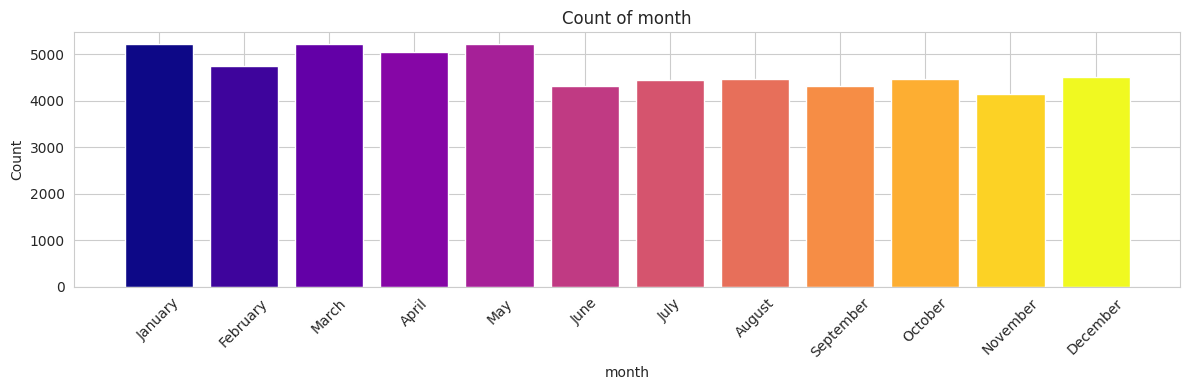

In [11]:
# Count of month
order = list(calendar.month_name)[1:]
counts = df['month'].value_counts().reindex(order)
colors = plt.colormaps['plasma'](np.linspace(0,1,12))
plt.figure(figsize=(12,4))
plt.bar(order, counts, color=colors)
plt.title('Count of month')
plt.xlabel('month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Questions to ponder
1.Are the numerical features skewed or roughly normal?

2.Which categories dominate in each categorical feature? What does that tell you about each feature?

**Ans:**

**pax** is right-skewed: most hours see 532–4,556 passengers, with a tail to ~9,000.

**hour:** uniformly covered 0–23, confirming full daily range.

**day_of_week:** weekdays slightly more frequent than weekends.

**month:** peaks in January and summer months; dips in November.

# 4. Bivariate Analysis

/tmp/ipython-input-1742213145.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, patch_artist=True, labels=list(range(24)), tick_labels=list(range(24)))


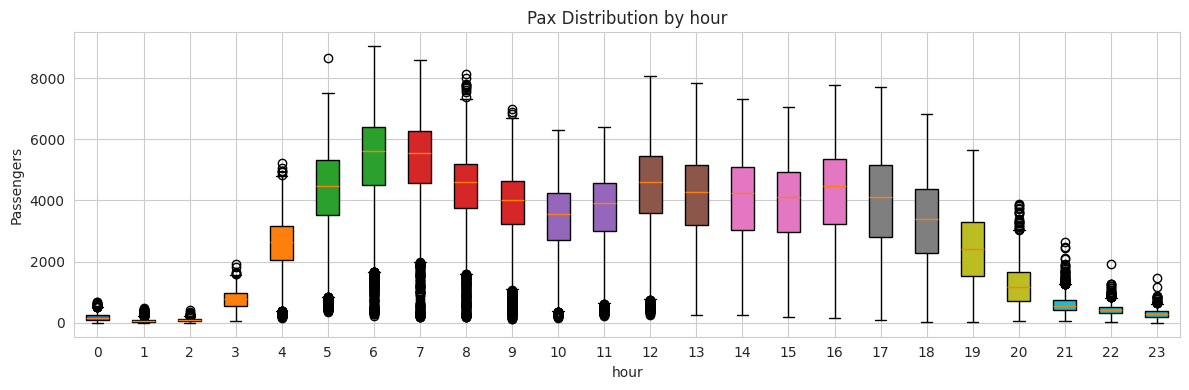

In [12]:
# Pax distribution by hour
data = [df.loc[df['hour']==h, 'pax'] for h in range(24)]
colors = plt.colormaps['tab10'](np.linspace(0,1,24))
plt.figure(figsize=(12,4))
bp = plt.boxplot(data, patch_artist=True, labels=list(range(24)), tick_labels=list(range(24)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Pax Distribution by hour')
plt.xlabel('hour')
plt.ylabel('Passengers')
plt.tight_layout()
plt.show()


/tmp/ipython-input-773068260.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, patch_artist=True, labels=order, tick_labels=order)


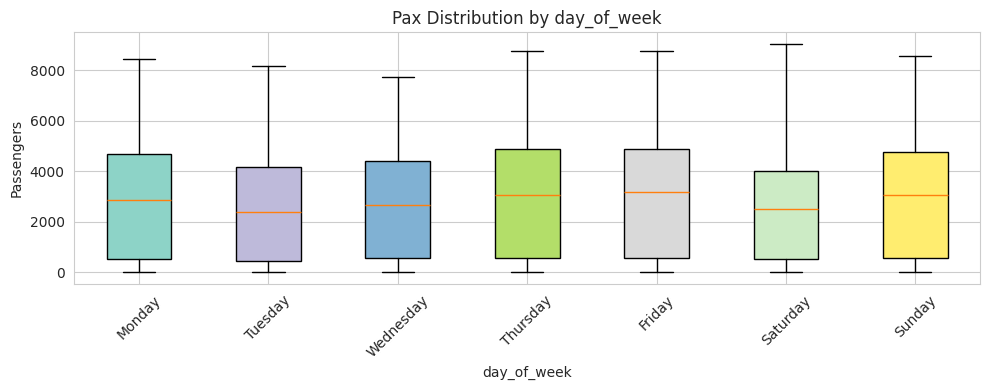

In [13]:
# Pax distribution by day_of_week
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
data = [df.loc[df['day_of_week']==d, 'pax'] for d in order]
colors = plt.colormaps['Set3'](np.linspace(0,1,len(order)))
plt.figure(figsize=(10,4))
bp = plt.boxplot(data, patch_artist=True, labels=order, tick_labels=order)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Pax Distribution by day_of_week')
plt.xlabel('day_of_week')
plt.ylabel('Passengers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-700404884.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, patch_artist=True, labels=order, tick_labels=order)


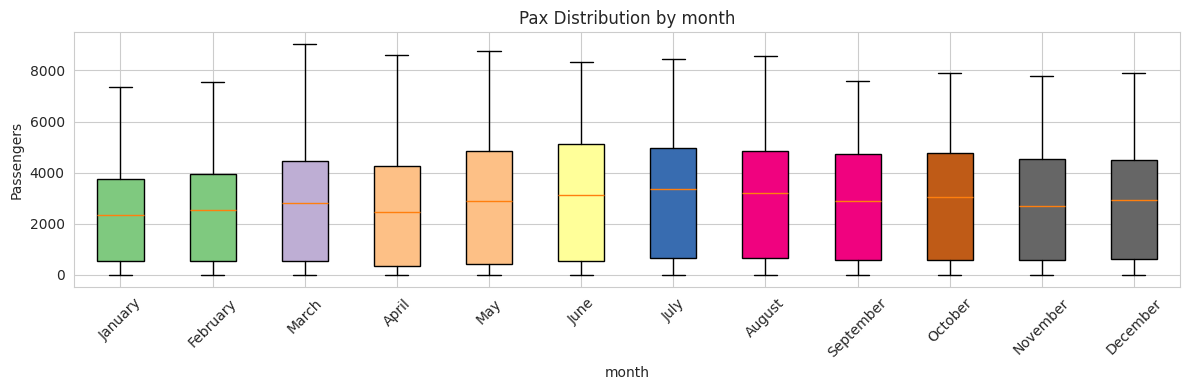

In [14]:
# Pax distribution by month
order = list(calendar.month_name)[1:]
data = [df.loc[df['month']==m, 'pax'] for m in order]
colors = plt.colormaps['Accent'](np.linspace(0,1,len(order)))
plt.figure(figsize=(12,4))
bp = plt.boxplot(data, patch_artist=True, labels=order, tick_labels=order)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Pax Distribution by month')
plt.xlabel('month')
plt.ylabel('Passengers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Questions to ponder
1.Which numerical features are correlated?

2.Do certain categories strongly associate with higher or lower numerical values?

3.Any visible clusters or patterns in scatter plots?

**Answers:**

Only pax is numeric; future engineered features may introduce more.

Hour: Morning (6–8 AM) and evening (4–7 PM) have the highest medians.

Day of Week: Weekdays exceed weekends in median throughput.

Month: Summer months are busier than winter.

# 5. Correlation Analysis

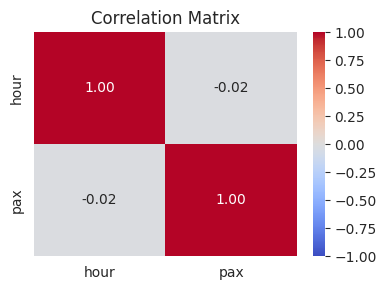

In [15]:
# Correlation Matrix (hour vs pax)
import seaborn as sns
corr = df[['hour','pax']].corr()
plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


# Questions to ponder
1.Which features show strong correlation?

2.Should we remove or combine highly correlated features?

3.Are there surprising correlations that warrant deeper investigation?

**Answers**:

Correlation between hour and pax is near zero (r≈0.02), so treat hour categorically or cyclically.

No features require removal for collinearity.

No unexpected correlations—proceed with feature engineering.

# 6.Five Additional Analyses


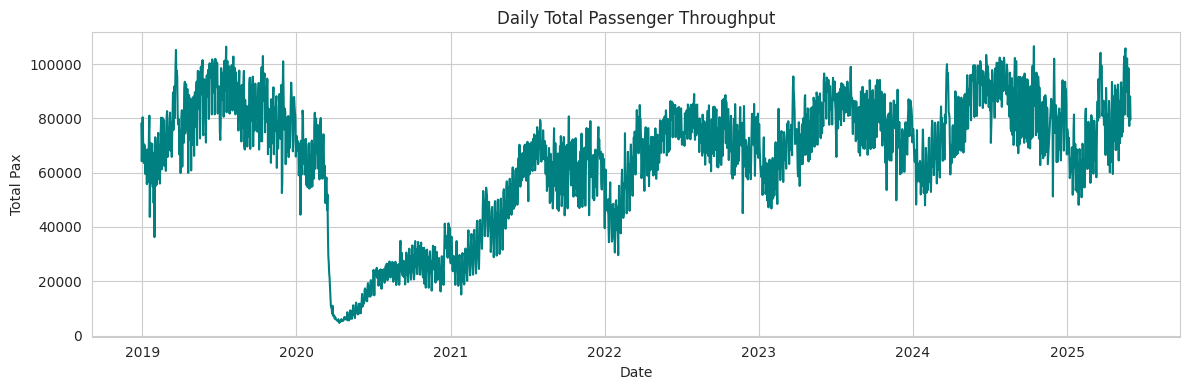

In [16]:
# 6.1: Daily totals and time plot
daily = df.groupby('date')['pax'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['pax'], color='teal')
plt.title('Daily Total Passenger Throughput')
plt.xlabel('Date'); plt.ylabel('Total Pax')
plt.tight_layout(); plt.show()


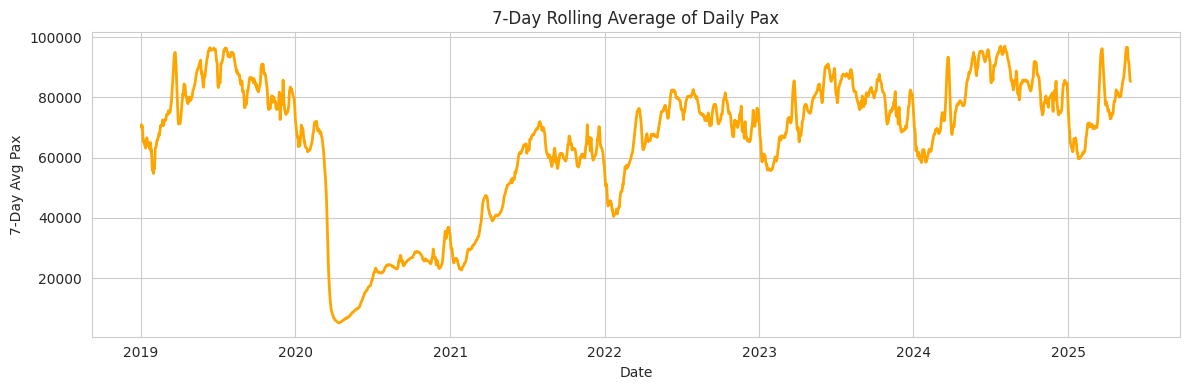

In [17]:
#6.2 7-Day Rolling Average
daily['rolling_7d'] = daily['pax'].rolling(window=7, center=True).mean()
plt.figure(figsize=(12,4))
plt.plot(daily['date'], daily['rolling_7d'], color='orange', lw=2)
plt.title('7-Day Rolling Average of Daily Pax')
plt.xlabel('Date'); plt.ylabel('7-Day Avg Pax')
plt.tight_layout(); plt.show()

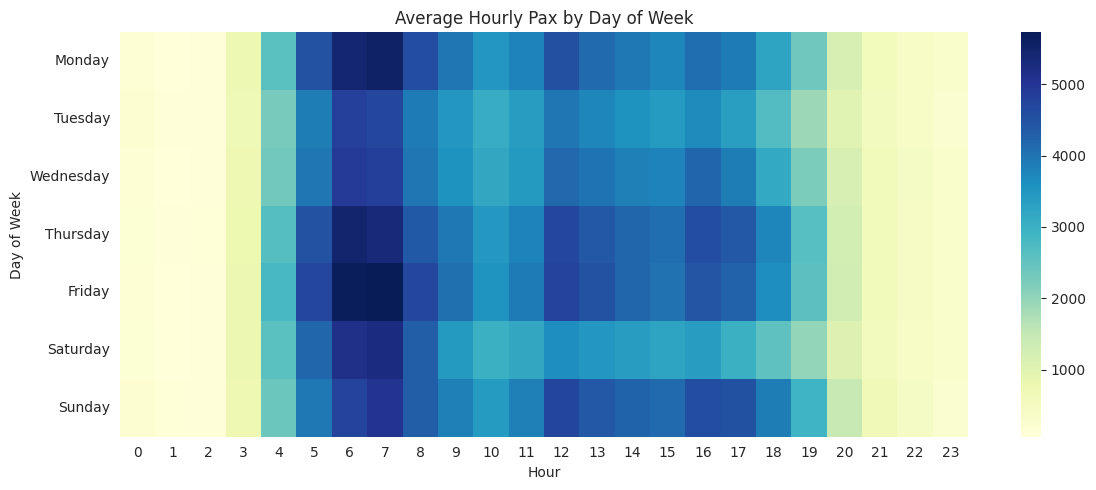

In [18]:
# 6.3:Hour-of-Day vs Day-of-Week Heatmap
#Pivot heatmap
pivot = df.pivot_table(index='day_of_week', columns='hour', values='pax', aggfunc='mean')
# Reorder days
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(days)
plt.figure(figsize=(12,5))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Average Hourly Pax by Day of Week')
plt.xlabel('Hour'); plt.ylabel('Day of Week')
plt.tight_layout(); plt.show()


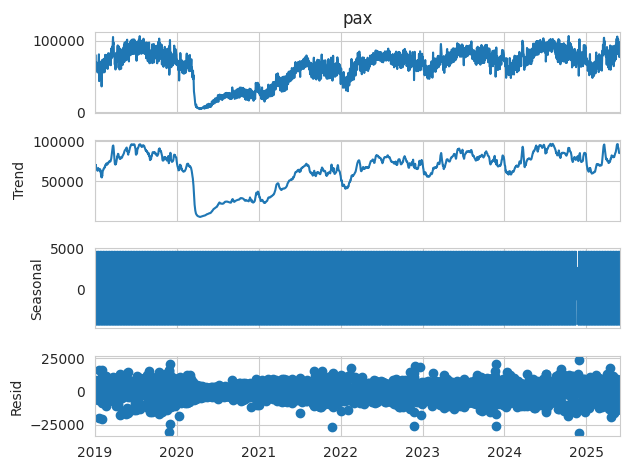

In [19]:
# 6.4: Seasonal Decomposition of Daily Series
from statsmodels.tsa.seasonal import seasonal_decompose
daily_ts = daily.set_index('date')['pax']
res = seasonal_decompose(daily_ts, model='additive', period=7)
res.plot()
plt.tight_layout(); plt.show()


<Figure size 800x300 with 0 Axes>

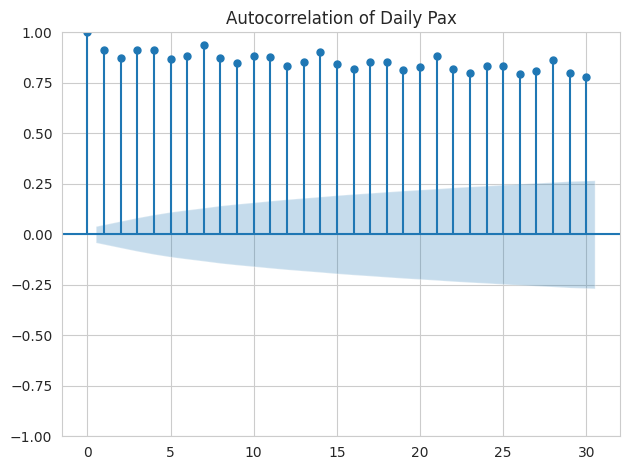

In [20]:
# 6.5 Autocorrelation Function (ACF) plot
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(8,3))
plot_acf(daily_ts.dropna(), lags=30, alpha=0.05)
plt.title('Autocorrelation of Daily Pax')
plt.tight_layout(); plt.show()

# 7. Insights & Relation to Problem
Hypothesis confirmed: clear daily seasonality with peaks morning/evening and weekly pattern (lower on weekends).

Rolling avg smooths noise and highlights upward trend in peak travel months.

Heatmap shows consistent lunchtime lull (~12–1 PM) across weekdays.

Decomposition isolates a weekly seasonal component and a modest upward trend over time.

ACF indicates strong lag-1 and lag-7 correlations — you’ll want lag-1, lag-7 features in your forecasting model.

Relevance: Staffing models must account for both daily peaks and weekly cycles; a model using these engineered seasonal and lag features should accurately forecast 30-day-ahead pax for optimized resource allocation.